In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import umap
import glob
import PyPDF2 
from natsort import natsorted 
import pickle


import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.font_manager as font_manager
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import random
import math

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import mutual_info_score
from scipy.stats import pearsonr
from matplotlib.colors import Normalize
from matplotlib import cm

/home/aabisheva/anaconda3/envs/nmf/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/aabisheva/anaconda3/envs/nmf/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/aabisheva/anaconda3/envs/nmf/lib/python3.11/site-packages/umap/d

In [2]:
method = "nndsvd"

results_filename = f'precision_recall_curve_results_{method}.pkl'

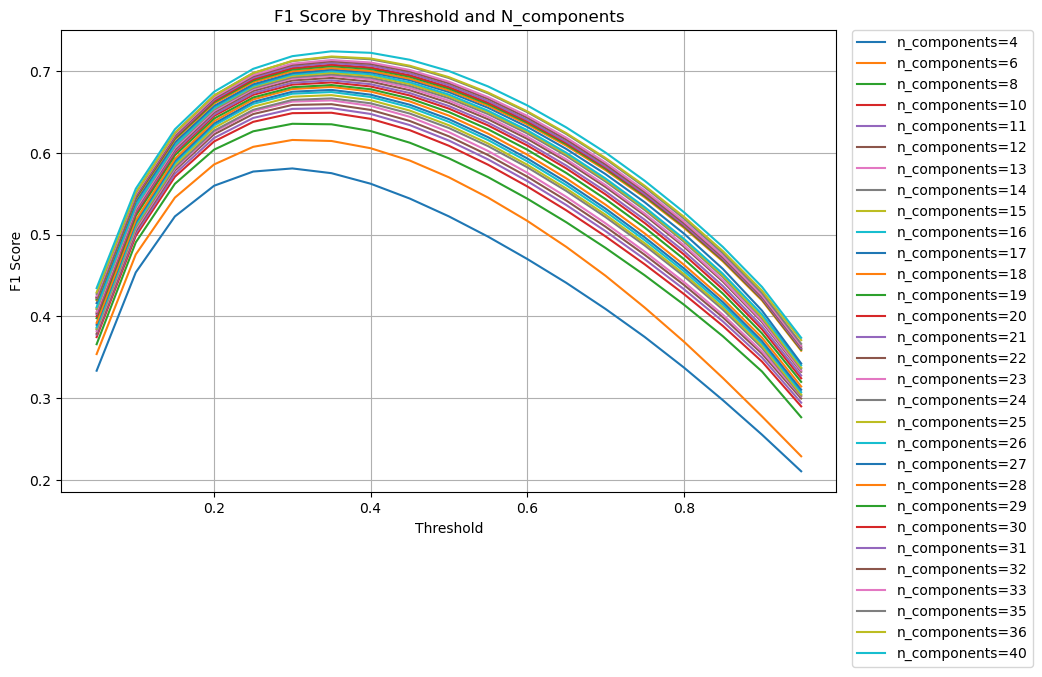

In [3]:
with open(results_filename, 'rb') as f:
    loaded_results = pickle.load(f)

plt.figure(figsize=(10, 6))
for n, dataframes in loaded_results.items():
    df = dataframes[1]
    df['precision'] = df['TP'] / (df['TP'] + df['FP'])
    df['recall'] = df['TP'] / (df['TP'] + df['FN'])
    df['F1'] = 2 * df['precision'] * df['recall'] / (df['precision'] + df['recall'])
    df['F1'].fillna(0, inplace=True)  # Fill NaN values with 0 (when both precision and recall are 0)
    plt.plot(df['threshold'], df['F1'], label=f'n_components={n}')

plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score by Threshold and N_components')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.grid()
plt.show()

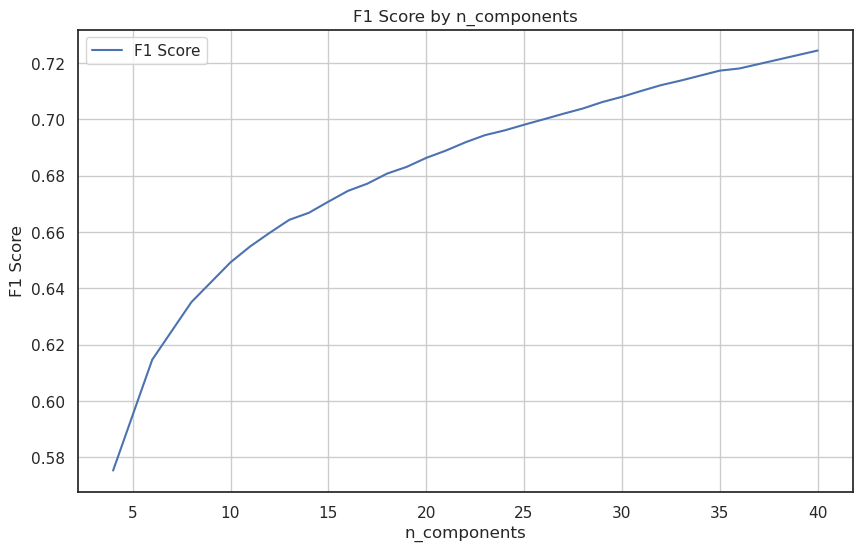

13


In [15]:
from sklearn.metrics import auc

n_values = []
auprc_values = []
f1_scores = []
threshold = 0.35

for n, dataframes in loaded_results.items():
    df = dataframes[1].copy()
    df = df[df['threshold'] <= threshold]  # Select rows up to the given threshold
    df['precision'] = df['TP'] / (df['TP'] + df['FP'])
    df['recall'] = df['TP'] / (df['TP'] + df['FN'])
    df['F1'] = 2 * df['precision'] * df['recall'] / (df['precision'] + df['recall'])
    df['F1'].fillna(0, inplace=True)  # Fill NaN values with 0 (when both precision and recall are 0)
    f1_score = df.loc[df['threshold'] == threshold, 'F1'].values[0]  # F1 score at the given threshold

    n_values.append(n)
    f1_scores.append(f1_score)
    
# Locate the knee point
knee_locator = KneeLocator(n_values, f1_scores, curve="concave", direction="increasing")
knee_point_x = knee_locator.knee

plt.figure(figsize=(10, 6))
plt.plot(n_values, f1_scores, label='F1 Score')
plt.xlabel('n_components')
plt.ylabel('F1 Score')
plt.title('F1 Score by n_components')
plt.legend()
plt.grid()
plt.show()
print(knee_point_x)

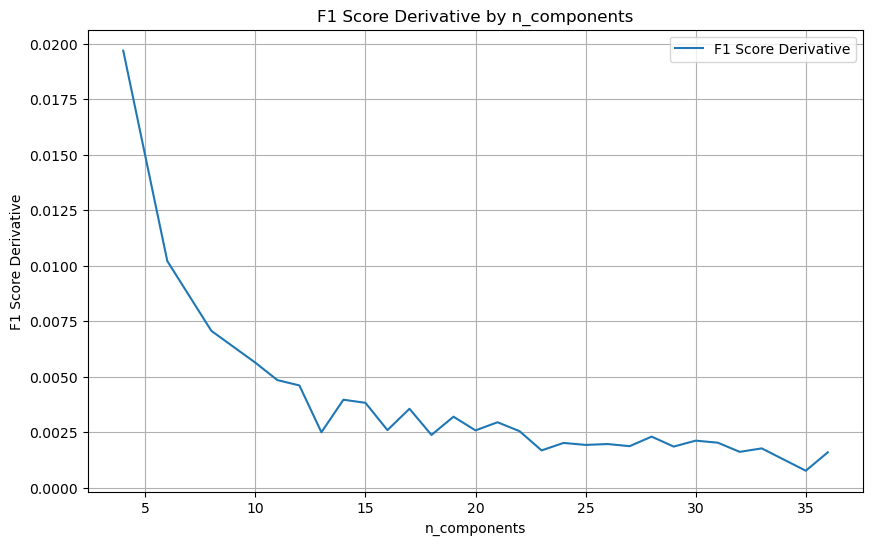

In [5]:
n_values = []
auprc_values = []
f1_scores = []
threshold = 0.35

for n, dataframes in loaded_results.items():
    df = dataframes[1].copy()
    df = df[df['threshold'] <= threshold]  # Select rows up to the given threshold
    df['precision'] = df['TP'] / (df['TP'] + df['FP'])
    df['recall'] = df['TP'] / (df['TP'] + df['FN'])
    df['F1'] = 2 * df['precision'] * df['recall'] / (df['precision'] + df['recall'])
    df['F1'].fillna(0, inplace=True)  # Fill NaN values with 0 (when both precision and recall are 0)
    f1_score = df.loc[df['threshold'] == threshold, 'F1'].values[0]  # F1 score at the given threshold

    n_values.append(n)
    f1_scores.append(f1_score)

f1_derivatives = np.diff(f1_scores) / np.diff(n_values)

plt.figure(figsize=(10, 6))
plt.plot(n_values[:-1], f1_derivatives, label='F1 Score Derivative')
plt.xlabel('n_components')
plt.ylabel('F1 Score Derivative')
plt.title('F1 Score Derivative by n_components')
plt.legend()
plt.grid()
plt.show()

/tmp/ipykernel_29282/2341378978.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


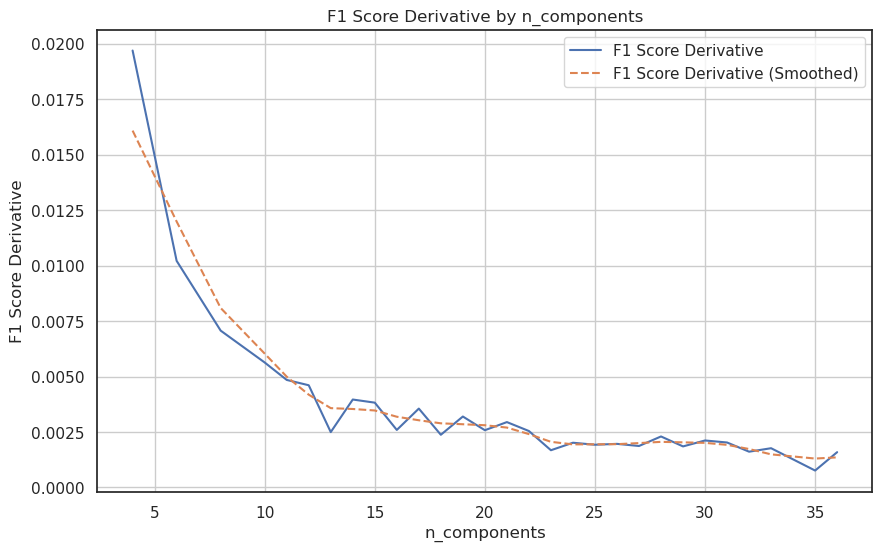

In [9]:
from scipy.ndimage.filters import gaussian_filter

# Apply Gaussian filter to smooth the derivative
sigma = 1  # You can adjust the sigma value to change the smoothness
f1_derivatives_smoothed = gaussian_filter(f1_derivatives, sigma=sigma)

plt.figure(figsize=(10, 6))
plt.plot(n_values[:-1], f1_derivatives, label='F1 Score Derivative')
plt.plot(n_values[:-1], f1_derivatives_smoothed, label='F1 Score Derivative (Smoothed)', linestyle='--')
plt.xlabel('n_components')
plt.ylabel('F1 Score Derivative')
plt.title('F1 Score Derivative by n_components')
plt.legend()
plt.grid()
plt.show()


/tmp/ipykernel_29282/3885096137.py:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


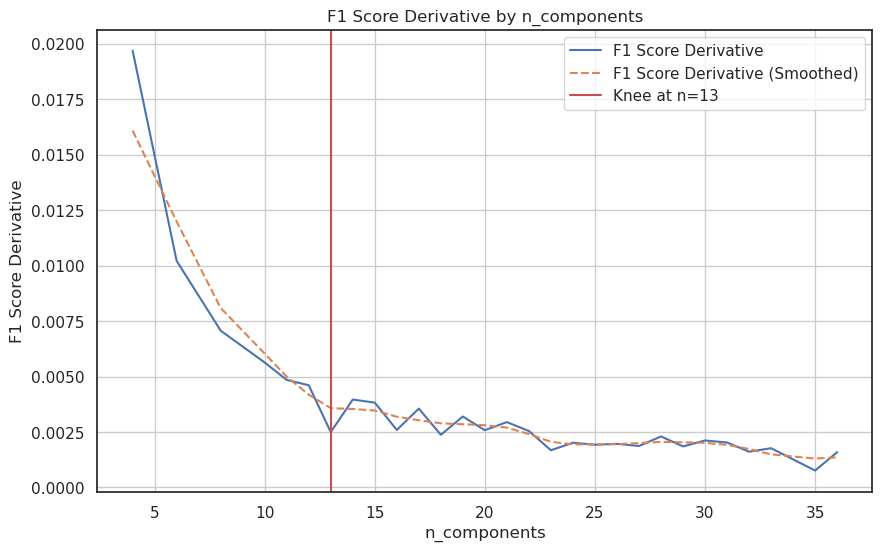

The knee point is located at n=13


In [11]:
from kneed import KneeLocator
from scipy.ndimage.filters import gaussian_filter

# Apply Gaussian filter to smooth the derivative
sigma = 1  # Adjust the sigma value to change the smoothness
f1_derivatives_smoothed = gaussian_filter(f1_derivatives, sigma=sigma)

# Locate the knee point
knee_locator = KneeLocator(n_values[:-1], f1_derivatives_smoothed, curve="convex", direction="decreasing")
knee_point_x = knee_locator.knee

# Plot the original and smoothed derivatives
plt.figure(figsize=(10, 6))
plt.plot(n_values[:-1], f1_derivatives, label='F1 Score Derivative')
plt.plot(n_values[:-1], f1_derivatives_smoothed, label='F1 Score Derivative (Smoothed)', linestyle='--')
plt.axvline(x=knee_point_x, color='r', linestyle='-', label=f'Knee at n={knee_point_x}')
plt.xlabel('n_components')
plt.ylabel('F1 Score Derivative')
plt.title('F1 Score Derivative by n_components')
plt.legend()
plt.grid()
plt.show()

print(f"The knee point is located at n={knee_point_x}")


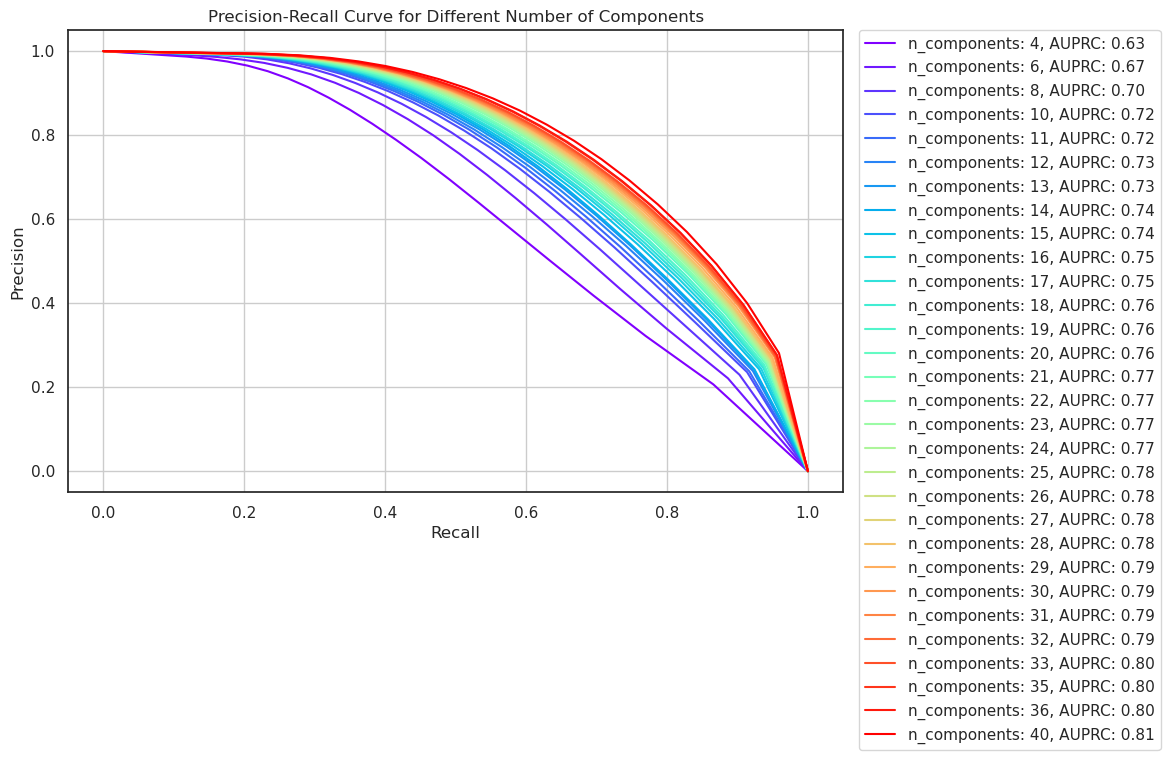

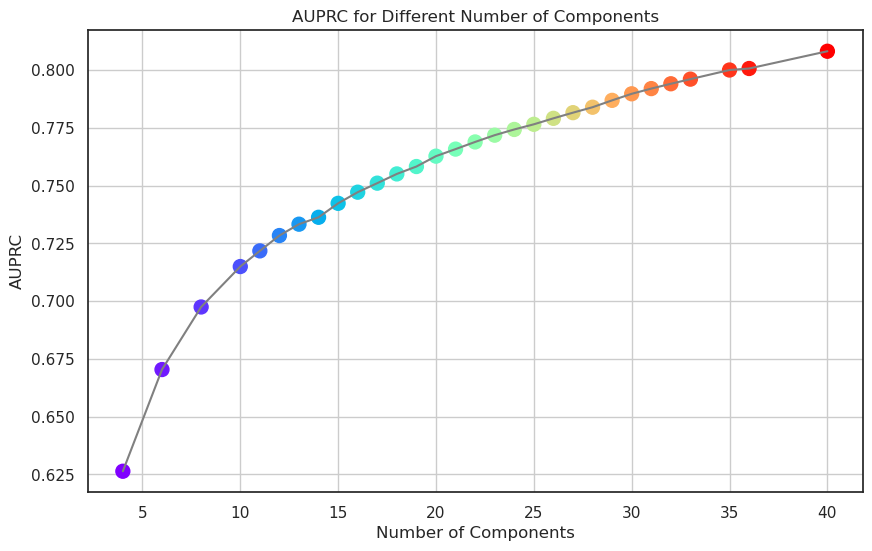

In [7]:
# Create a color map
colors = cm.rainbow(np.linspace(0, 1, len(loaded_results)))

plt.figure(figsize=(10, 6))

# Container for AUC scores
auprc_scores = []

# For each number of components, calculate and plot PRC
for (n, dataframes), color in zip(loaded_results.items(), colors):
    df = dataframes[1].copy()
    
    df['precision'] = df['TP'] / (df['TP'] + df['FP'])
    df['recall'] = df['TP'] / (df['TP'] + df['FN'])

    precision_values = df['precision'].values
    recall_values = df['recall'].values

    # Add points (0, 1) and (1, 0)
    precision_values = np.insert(precision_values, 0, 1)
    recall_values = np.insert(recall_values, 0, 0)
    precision_values = np.append(precision_values, 0)
    recall_values = np.append(recall_values, 1)

    # Sort recall and corresponding precision values in ascending order
    sort_indices = np.argsort(recall_values)
    recall_values = recall_values[sort_indices]
    precision_values = precision_values[sort_indices]

    # Calculate area under the curve
    area = auc(recall_values, precision_values)
    auprc_scores.append((n, area))
    
    plt.plot(recall_values, precision_values, color=color, label=f'n_components: {n}, AUPRC: {area:.2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Different Number of Components')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.grid()
plt.show()

# Plotting AUPRC scores
n_components, scores = zip(*auprc_scores)

plt.figure(figsize=(10, 6))
plt.scatter(n_components, scores, c=colors, s=100)
plt.plot(n_components, scores, linestyle='-', color='grey')
plt.xlabel('Number of Components')
plt.ylabel('AUPRC')
plt.title('AUPRC for Different Number of Components')
plt.grid()
plt.show()
